In [3]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
% matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Part I: Manipulating Finacial Data in Python

## Define three utility functions 

In [4]:
def symbol_to_path(symbol, base_dir = os.path.join("..", "data")):
    """return CSV file path of specific symbol (stock name) in local directory"""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates, adSPY = True):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index = dates)
    
    # add S&P 500 to the data if reqiured and missing
    if 'SPY' not in symbols and adSPY:
        symbols = ["SPY"] + symbols
        
    for symbol in symbols:
        df_symbol = pd.read_csv(symbol_to_path(symbol), index_col = 'Date', parse_dates = True,
                               usecols=['Date', 'Adj Close'], na_values=['nan'])
        # rename the column so as to avoid error of same column name
        df_symbol = df_symbol.rename(columns = {"Adj Close":symbol})
        df = df.join(df_symbol)
        df = df.dropna()
    return df

def plot_data(df, title = "Stock Prices", xlabel = 'Date', ylabel = 'Price'):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title = title, fontsize = 12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

## Assess Portfolios


In [18]:
def calculate_daily_return(port_daily_value):
    """Helper function. Compute daily return 
    Parameters
    ----------
        port_daily_value: DataFrame, the daily value of the portfolio
    Returns
    -------
       dr: daily return"""
    dr = port_daily_value.copy()
    dr[1:] = (port_daily_value[1:] / port_daily_value[0:-1].values) -1 
    dr[0] = 0.0
    return dr

def get_portfolio_stats(port_daily_value, dr, rfr, sf):
    """ Helper function. Compute portfolio statistics 
    Parameters
    ----------
        port_daily_value: DataFrame, the daily value of the portfolio
        dr: daily return
        rfr: risk free rate
        sf: sampling frequency, by default set to 252 days 
       
    Returns
    -------
        cr: cumulative return 
        adr: average period return (equals to average daily return if sf = 252) 
        sddr: standard deviation of daily returns
        sr: sharpe ratio
        ev: ending value of the portfolio"""

    def calculate_sharpe_raio(dr, rfr, sf):
        """Helper function. Compute sharpe ratio 
        Parameters
        ----------
            dr: daily return
            rfr: risk free rate
            sf: sampling frequency, by default set to 252 days 
        Returns
        -------
            sr: sharpe ratio """
        adr = dr.mean()
        sddr = np.std(dr)
        k = sf ** 0.5
        return (adr - rfr) / sddr * k

    # calculate daily returns (dr)
    dr = calculate_daily_return(port_daily_value)
    
    # Average daily return
    adr = dr.mean()
   
    # Cumulative return
    cr = (port_daily_value[-1] / port_daily_value[0]) -1
    
    # Standard deviation of daily return
    sddr = np.std(dr)
    
    
    #Sharpe Ratio : mean(daily returns - risk free rate) / standard deviation of daily return * sqrt(sampling frequency)
    sr = calculate_sharpe_raio(dr, rfr, sf)
    
    # End Value
    ev = port_daily_value[-1]
    
    return adr, cr, sddr, sr, ev
    
def normalized(prices):
    # normalize the input dataframe
    return prices / prices.ix[0]
    
def assess_portfolio(sd, ed, syms, allocs, sv = 1000000, rfr = 0.0, sf = 252.0, gen_plot = True):
    """Compute portfolio statistics and plot line chart comparing to S&P 500 given the description of portfolio.
    Parameters
    ----------
        sd: first date to track
        ed: last date to track
        syms: symbols, a list of stock names
        sv: starting value of the portfolio
        rfr: risk free rate
        sf: sampling frequency, by default set to 252 days 
        gen_plot: wheather or not to plot normalized price chart
        
    Returns
    -------
        cr: cumulative return 
        adr: average period return (equals to average daily return if sf = 252) 
        sddr: standard deviation of daily returns
        sr: sharpe ratio
        ev: ending value of the portfolio"""

    # Read in adjusted closing prices for given symbols, date range
    dates = pd.date_range(sd, ed)
    prices_all = get_data(syms, dates)
    prices_syms = prices_all[syms] # only portfolio symbols
    prices_spy = prices_all['SPY']  # only SPY, for comparison later
    
    
    
    # Get daily portfolio value
    normalized_syms = normalized(prices_syms)
    allocated_port = normalized_syms * allocs
    port = allocated_port * sv
    port_daily_value = port.sum(axis = 1) #sum up each row
    
    # normalization for comparision and plotting
    normalized_spy = normalized(prices_spy) 
    normalized_port = normalized(port_daily_value) 
    
    dr = calculate_daily_return(port_daily_value)
    
    adr, cr, sddr, sr, ev = get_portfolio_stats(port_daily_value, dr, rfr, sf)
    
    
    # Compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        # add code to plot here
        
        df_temp = pd.concat([normalized_port, normalized_spy], keys=['Portfolio', 'SPY'], axis=1)
        plot_data(df_temp)
        
        print "Start Date:", sd.strftime('%Y-%m-%d')
        print "End Date:", ed.strftime('%Y-%m-%d')
        print "Symbols:", syms
        print "Allocations:", allocs, "\n"
        
    
        print "Cumulative Return: ", cr
        print "Average Daily Return: ", adr
        print "Volatility (stdev of daily returns): ", sddr
        print "Sharpe Ratio: ", sr
        print "End Value of Portfolio: \n", ev 
        
        print prices_all.head()
    
    return cr, adr, sddr, sr, ev
    

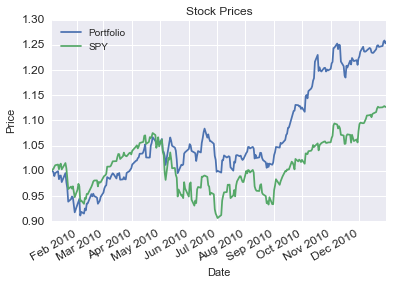

Start Date: 2010-01-01
End Date: 2010-12-31
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Allocations: [0.2, 0.3, 0.4, 0.1] 

Cumulative Return:  0.255646784534
Average Daily Return:  0.00095356716188
Volatility (stdev of daily returns):  0.00997078151393
Sharpe Ratio:  1.51817682408
End Value of Portfolio: 
1255646.78453
               SPY    GOOG    AAPL     GLD    XOM
2010-01-04  108.27  626.75  213.10  109.80  64.55
2010-01-05  108.56  623.99  213.46  109.70  64.80
2010-01-06  108.64  608.26  210.07  111.51  65.36
2010-01-07  109.10  594.10  209.68  110.82  65.15
2010-01-08  109.46  602.02  211.07  111.37  64.89


(0.25564678453350465,
 0.0009535671618800534,
 0.009970781513932516,
 1.5181768240776041,
 1255646.7845335046)

In [19]:
assess_portfolio(sd = dt.datetime(2010,1,1), ed = dt.datetime(2010,12,31), syms = ['GOOG', 'AAPL', 'GLD', 'XOM'], 
                 allocs = [0.2, 0.3, 0.4, 0.1], sv = 1000000, rfr = 0.0, sf = 252.0, gen_plot = True)

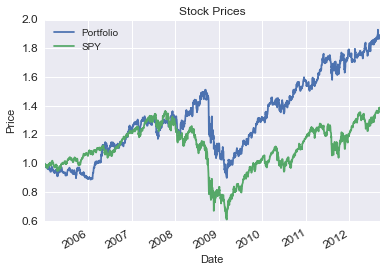

Start Date: 2005-01-01
End Date: 2012-12-31
Symbols: ['AXP', 'HPQ', 'IBM', 'HNZ']
Allocations: [0.0, 0.0, 0.0, 1.0] 

Cumulative Return:  0.89139206456
Average Daily Return:  0.000398645687307
Volatility (stdev of daily returns):  0.0118352298173
Sharpe Ratio:  0.534700567439
End Value of Portfolio:  1891392.06456
               SPY    AXP    HPQ    IBM    HNZ
2005-01-03  103.92  43.19  19.32  86.54  29.74
2005-01-04  102.65  42.54  19.19  85.61  29.52
2005-01-05  101.94  42.14  19.27  85.43  29.39
2005-01-06  102.46  41.93  19.24  85.17  29.22
2005-01-07  102.31  41.62  19.13  84.79  29.26


(0.89139206455951614,
 0.0003986456873073859,
 0.011835229817263409,
 0.5347005674390718,
 1891392.064559516)

In [7]:
assess_portfolio(sd = '2005-01-01', ed = '2012-12-31', syms = ['AXP', 'HPQ', 'IBM', 'HNZ'], 
                 allocs = [0.0, 0.0, 0.0, 1.0], sv = 1000000, rfr = 0.0, sf = 252.0, gen_plot = True)

# Optimizing Portfolios

In [8]:
import scipy.optimize as spo

def opitimize_portfolio(sd, ed, syms, gen_plot = True):
    """Compute optimal allocations for a given set of stocks by  maximizing Sharpe ratio and generate portfolio statistics
       for the optimal portfolio. In additon, plot line chart comparing to S&P 500.
    Parameters
    ----------
        sd: first date to track
        ed: last date to track
        syms: symbols, a list of stock names
        gen_plot: wheather or not to plot normalized price chart
        
    Returns
    -------
        cr: cumulative return 
        adr: average period return (equals to average daily return if sf = 252) 
        sddr: standard deviation of daily returns
        sr: sharpe ratio
        ev: ending value of the portfolio"""
    
    # Read in adjusted closing prices for given symbols, date range
    dates = pd.date_range(sd, ed)
    prices_all = get_data(syms, dates)
    prices_syms = prices_all[syms] # only portfolio symbols
    prices_spy = prices_all['SPY']  # only SPY, for comparison later
    
    
    def inverse_sr(allocs):
        sr = assess_portfolio(sd = sd, ed = ed, syms = syms, allocs = allocs, gen_plot = False)[3]
        return 1 / sr


    def get_optimize_allocations(f, initial_allocs):
        """Helper function. Compute optimized allocation
        Parameters
        ----------
            f: function to minimize
            initial_allocs: initial guess of allocations
        Returns
        -------
            min_result: optimized allocation that provides highest sharpe ratio"""    
        bounds = [tuple((0, 1)) for i in initial_allocs]
        constraints = ({'type' : 'eq', 'fun' : lambda x: 1.0 - np.sum(x)})
    
        min_result = spo.minimize(fun = f, x0 = initial_allocs, method = "SLSQP", options = {"disp" : True}, bounds = bounds, constraints = constraints)
        return min_result
    
    
    # find the allocations for the optimal portfolio
    initial_allocs = [1.0 / len(syms) for i in range(len(syms))] 
    
    
    optimized_allocs = get_optimize_allocations(inverse_sr, initial_allocs) 
    print np.sum((optimized_allocs))
    print optimized_allocs
    
    return assess_portfolio(sd = sd, ed = ed, syms = syms, allocs = optimized_allocs['x'])
    
   


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.499010288374
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6
  status: 0
 success: True
    njev: 6
    nfev: 36
     fun: 0.4990102883742346
       x: array([ -2.84941045e-21,   3.97184021e-01,   6.02815979e-01,
         5.78288649e-17])
 message: 'Optimization terminated successfully.'
     jac: array([  4.03016370e-01,   3.80355865e-04,  -2.50618905e-04,
         1.29900865e-01,   0.00000000e+00])
     nit: 6
  status: 0
 success: True
    njev: 6
    nfev: 36
     fun: 0.4990102883742346
       x: array([ -2.84941045e-21,   3.97184021e-01,   6.02815979e-01,
         5.78288649e-17])
 message: 'Optimization terminated successfully.'
     jac: array([  4.03016370e-01,   3.80355865e-04,  -2.50618905e-04,
         1.29900865e-01,   0.00000000e+00])
     nit: 6


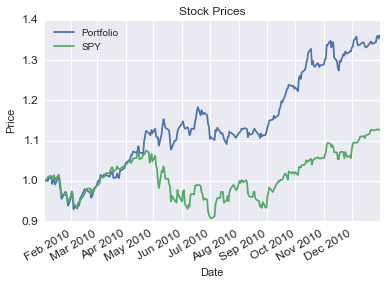

Start Date: 2010-01-01
End Date: 2010-12-31
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Allocations: [ -2.84941045e-21   3.97184021e-01   6.02815979e-01   5.78288649e-17] 

Cumulative Return:  0.360218165639
Average Daily Return:  0.0012724392777
Volatility (stdev of daily returns):  0.0100796821328
Sharpe Ratio:  2.00396669828
End Value of Portfolio:  1360218.16564
               SPY    GOOG    AAPL     GLD    XOM
2010-01-04  108.27  626.75  213.10  109.80  64.55
2010-01-05  108.56  623.99  213.46  109.70  64.80
2010-01-06  108.64  608.26  210.07  111.51  65.36
2010-01-07  109.10  594.10  209.68  110.82  65.15
2010-01-08  109.46  602.02  211.07  111.37  64.89


(0.36021816563885456,
 0.0012724392777003243,
 0.010079682132798345,
 2.0039666982778646,
 1360218.1656388543)

In [9]:
opitimize_portfolio(sd = '2010-01-01', ed = '2010-12-31', syms = ['GOOG', 'AAPL', 'GLD', 'XOM'])

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.18666671261
            Iterations: 3
            Function evaluations: 19
            Gradient evaluations: 3
  status: 0
 success: True
    njev: 3
    nfev: 19
     fun: 1.1866667126088042
       x: array([  7.75407663e-01,   2.24592337e-01,   9.28049835e-16,
         1.04249704e-15])
 message: 'Optimization terminated successfully.'
     jac: array([  1.97321177e-04,  -6.79954886e-04,   8.29717949e-01,
         4.10689905e-01,   0.00000000e+00])
     nit: 3
  status: 0
 success: True
    njev: 3
    nfev: 19
     fun: 1.1866667126088042
       x: array([  7.75407663e-01,   2.24592337e-01,   9.28049835e-16,
         1.04249704e-15])
 message: 'Optimization terminated successfully.'
     jac: array([  1.97321177e-04,  -6.79954886e-04,   8.29717949e-01,
         4.10689905e-01,   0.00000000e+00])
     nit: 3


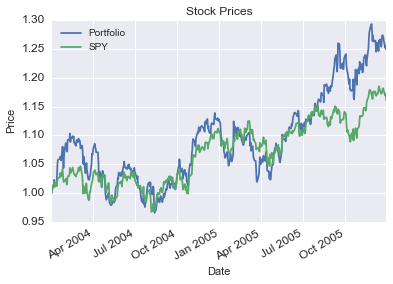

Start Date: 2004-01-01
End Date: 2006-01-01
Symbols: ['AXP', 'HPQ', 'IBM', 'HNZ']
Allocations: [  7.75407663e-01   2.24592337e-01   9.28049835e-16   1.04249704e-15] 

Cumulative Return:  0.255015025345
Average Daily Return:  0.000493950443814
Volatility (stdev of daily returns):  0.00930491500462
Sharpe Ratio:  0.842696596588
End Value of Portfolio:  1255015.02535
              SPY    AXP    HPQ    IBM    HNZ
2004-01-02  94.28  36.66  20.93  80.43  26.84
2004-01-05  95.30  36.98  21.39  81.75  26.98
2004-01-06  95.40  37.04  21.48  81.75  27.19
2004-01-07  95.72  37.15  21.11  81.51  26.93
2004-01-08  96.10  37.04  22.31  81.74  26.90


(0.25501502534503628,
 0.0004939504438141325,
 0.009304915004616322,
 0.8426965965882447,
 1255015.0253450365)

In [10]:
opitimize_portfolio(sd = '2004-01-01', ed = '2006-01-01', syms = ['AXP', 'HPQ', 'IBM', 'HNZ'])

# Part II: Build a Market Simulator


In [27]:
def compute_portvals(orders_file = "./orders/orders.csv", start_val = 1000000):
    """Create a market simulator that accepts trading orders, keeps track of a portfolio's value over time and then 
       assesses the performance of that portfolio.
    Parameters
    ----------
        orders_file: csv file that include dates, symbols (stock code), order (Buy or Sell) and number of shares
        start_val: cash holdings at the start
        
    Returns
    -------
        delta_daily_value: showing cash flow of each day and the total value of the portfolio"""
    
    order_df = pd.read_csv(orders_file, index_col='Date', parse_dates=True, na_values=['nan'])
    order_df.sort_index(inplace = True)
    # read in the starting and ending date
    sd = order_df.index.values[0]
    ed = order_df.index.values[-1]
    
    # create a dataframe containing all price info for all symbols in th order file
    dates = pd.date_range(sd, ed)
    syms = np.unique(order_df['Symbol'])
    prices_all = get_data(syms, dates, adSPY = False)
    prices_all['Cash'] = 1.0
    
    # create a dataframe that record the order and update number of shares each day
    trace = prices_all.copy()
    trace.ix[:, :] = 0.0
    trace['Cash'] = 1000000

    def read_order(order_df, trace):
        """ the function read orders into trace """
        
        dates = order_df.index.values
        for i in range(len(order_df)):
            day = dates[i]
            
            symbol = order_df.ix[i][0]
            order = order_df.ix[i][1]
            if order == "BUY":
                shares = order_df.ix[i][2]
            else:
                shares = order_df.ix[i][2] * -1
            
            trace[symbol].loc[day:] += shares
            # calculate the cash balance everytime buying or selling shares
            trace['Cash'].loc[day:] -= shares * prices_all.loc[day][symbol]
        return trace
    read_order(order_df, trace)
    
    # create a dataframe that represent the cash value of the each stocks and the aggregate value of the portfolio
    delta_daily_value = prices_all * trace
    delta_daily_value["Total Value"] = delta_daily_value.apply(np.sum, axis = 1)
    port_daily_value = delta_daily_value["Total Value"]
    
    # Use S&P 500 as comparison and plot the graph
    prices_spy = get_data(["SPY"], dates)
    
    normalized_spy = normalized(prices_spy) 
    normalized_port = normalized(port_daily_value)
    df_temp = pd.concat([normalized_port, normalized_spy], axis=1)
    df_temp.columns = ['Portfolio', 'SPY']
                            
    plot_data(df_temp)
    

    # get portfolio statistics
    adr, cr, sddr, sr, ev = get_portfolio_stats(port_daily_value, 
                                                calculate_daily_return(port_daily_value), rfr = 0, sf = 252)
    # get S&P 500 statistics
    prices_spy = prices_spy.unstack() #since port_daily_value reqires input as Series
    adr_spy, cr_spy, sddr_spy, sr_spy, ev_spy = get_portfolio_stats(port_daily_value = prices_spy, 
                                                                    dr = calculate_daily_return(prices_spy), rfr = 0, sf = 252)
    
    
    print 'Data Range: {} to {} \n'.format(dates[0].strftime('%Y-%m-%d'), dates[-1].strftime('%Y-%m-%d'))
    
    print 'Sharpe Ratio of Fund: {}'.format(sr)
    print 'Sharpe Ratio of $SPX: {} \n'.format(sr_spy)

    print 'Cumulative Return of Fund: {}'.format(cr)
    print 'Cumulative Return of $SPX: {} \n'.format(cr_spy)
    
    print 'Standard Deviation of Fund: {}'.format(sddr)
    print 'Standard Deviation of $SPX: {} \n'.format(sddr_spy)
    
    print 'Average Daily Return of Fund: {}'.format(adr)
    print 'Average Daily Return of $SPX: {} \n'.format(adr_spy)
    
    print 'Final Portfolio Value: {} \n'.format(ev)
    
    print 'Top five rows of stock prices'
    print  prices_all.head()
    print  '\nList of Orders'
    print order_df
    
    return delta_daily_value


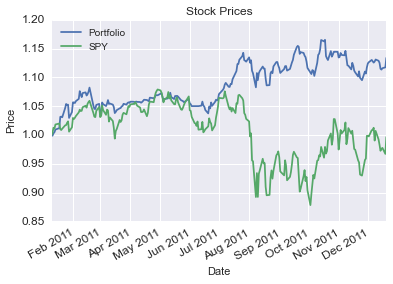

Data Range: 2011-01-10 to 2011-12-20 

Sharpe Ratio of Fund: 1.21540462111
Sharpe Ratio of $SPX: 0.10153868281 

Cumulative Return of Fund: 0.13386
Cumulative Return of $SPX: -0.00357171848364 

Standard Deviation of Fund: 0.00717514512699
Standard Deviation of $SPX: 0.0147476298196 

Average Daily Return of Fund: 0.000549352749569
Average Daily Return of $SPX: 9.43307924283e-05 

Final Portfolio Value: 1133860.0 

Top five rows of stock prices
              AAPL    GOOG     IBM    XOM  Cash
2011-01-10  340.99  614.21  143.41  72.02     1
2011-01-11  340.18  616.01  143.06  72.56     1
2011-01-12  342.95  616.87  144.82  73.41     1
2011-01-13  344.20  616.69  144.55  73.54     1
2011-01-14  346.99  624.18  145.70  74.62     1

List of Orders
           Symbol Order  Shares
Date                           
2011-01-10   AAPL   BUY    1500
2011-01-13   AAPL  SELL    1500
2011-01-13    IBM   BUY    4000
2011-01-26   GOOG   BUY    1000
2011-02-02    XOM  SELL    4000
2011-02-10    XOM   BUY

,AAPL,GOOG,IBM,XOM,Cash,Total Value
2011-01-10,511485,0,0,0,488515,1000000
2011-01-11,510270,0,0,0,488515,998785
2011-01-12,514425,0,0,0,488515,1002940
2011-01-13,0,0,578200,0,426615,1004815
2011-01-14,0,0,582800,0,426615,1009415
2011-01-18,0,0,585320,0,426615,1011935
2011-01-19,0,0,604880,0,426615,1031495
2011-01-20,0,0,605320,0,426615,1031935
2011-01-21,0,0,604160,0,426615,1030775
2011-01-24,0,0,620200,0,426615,1046815


In [ ]:
compute_portvals(orders_file = "./orders/orders.csv", start_val = 1000000)

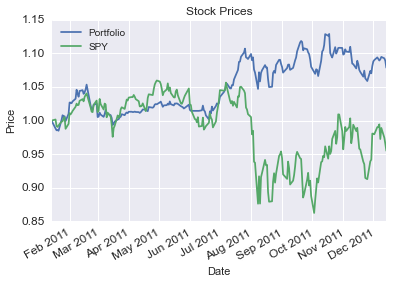

In [ ]:
compute_portvals(orders_file = "./orders/orders2.csv", start_val = 1000000)